# Gaussian Dispersion Models

Gaussian dispersion models are some of the simplest dispersion models and are used routinely for neutrally buoyant releases as well as for quick order-of-magnitude estimates for all kinds of releases. They are also typically the limiting behaviour for dense gas models as the density of the cloud trends towards the ambient conditions.


In [2]:
using GasDispersion

using Plots

# Gaussian Plume

The gaussian plume model assumes that concentration profile in the crosswind (y) and vertical (z) directions follow gaussian distributions with dispersions $\sigma_y$ and $\sigma_z$, respectively. This model can be derived from an advection-diffusion equation, or simply taken as a given.

The basic gaussian would have the plume expand downward beyond the ground, to correct for this an additional term for *ground reflection* is added. This is equivalent to adding a mirror image source reflected across the x-z plane, and causes mass to accumulate along the ground instead of simply disappearing (as would happen in the naive case). A similar term can be added to reflect back mass at higher elevations, due to inversions.

Putting this together the concentration for the plume model is given as:

$$ c_{plume} = {Q \over 2 \pi u \sigma_{y} \sigma_{z} }
\exp \left[ -\frac{1}{2} \left( y \over \sigma_{y} \right)^2 \right]
\left\{ \exp \left[ -\frac{1}{2} \left( { z -h } \over \sigma_{z} \right)^2 \right] + \exp \left[ -\frac{1}{2} \left( { z + h } \over \sigma_{z} \right)^2 \right] \right\} $$

with
- $c_{plume}$ - mass concentration (kg/m^3)
- *Q* - mass emission rate (kg/s)
- *u* - windspeed (m/s)
-  $\sigma_y$  - crosswind dispersion (m)
-  $\sigma_z$  - vertical dispersion (m)
- *h* - release elevation (m)


### Example
This scenario is adapted from *Guidelines for Consequence Analysis of Chemical Releases*, pg 97, where we are given the following for a chemical release

- mass emission rate - 0.1kg/s
- jet diameter - 10cm
- jet density - 1.225 kg/m^3
- release elevation - 0m
- windspeed - 2m/s
- stability - F
- pressure - 1atm
- temperature - 298K

and we wish to determine the groundlevel concentration at a point 500m downwind, this could be at the fenceline for example.

Further we assume the plume is neutrally buoyant and there is no plume rise.

In [3]:
Q = 0.1  # kg/s
u = 2.0  # m/s
h = 0.0  # m

Dⱼ = 10/100 # m
ρⱼ = 1.225  # kg/m^3
uⱼ = (Q/ρⱼ)/(0.25*π*Dⱼ^2) # m/s

10.393792201919695

The point we are interested in is at x=500, y=0, z=0. The concentration an be simplified to:

$$ c_{plume} = {Q \over { \pi \sigma_y \sigma_z u }} $$

and we can look up correlations for $\sigma_y$ and $\sigma_z$ in a standard reference, where they are tabulated by Pasquill stability class.

For class F we have
- $\sigma_y = 0.0674 x^{0.9}$
- $\sigma_z = 0.01122 x^{1.4024} \exp \left(-0.0540 \ln \left( x \right)^2 \right)$

In [4]:
x₁ = 500.0
σy = 0.0674*x₁^0.9
σz = 0.01122*(x₁^1.4024)*exp(-0.0540*log(x₁)^2)

σy, σz

(18.10226425693628, 8.4973632732228)

and finally calculate the groundlevel concentration at 500m downwind.

In [5]:
c₁ = Q / (π*σy*σz*u)

0.00010346728324507407

Which we can compare with the result from `GasDispersion.jl` 

In [6]:
ex1 = Scenario( Dict([
    :mass_emission_rate => Q,
    :jet_diameter => Dⱼ,
    :jet_velocity => uⱼ,
    :release_height => h,
    :windspeed => u,
    :pasquill_gifford => "F"
]))

c_g = plume(ex1, GaussianPlume())

c_g(x₁, 0, h) ≈ c₁

true

This answer compares well with the value in the text of $ 1.17 \times 10^{-4} kg/m^3 $, with the difference being entirely due to a different set of dispersion correlations.

The text has:
- $\sigma_y = 19.52 \textrm{m}$
- $\sigma_z = 6.96 \textrm{m}$

Based on a different set of correlations than the reference used in `GasDispersion.jl`.

# Stack Downwash

//TODO

# Plume Rise
The plume rising out of a stack will rise higher than the stack height due to buoyancy and because the plume is ejected with some kinetic energy. What follows is essentially a simplified version of the Brigg's model for stable plume rise.

### Example

This example extends the previous one, where we assume the release point has been elevated to 1m, as well as assume an ambient and release temperature:
+ $h = 1.0\mathrm{m}$
+ $T_{a} = 298\mathrm{K}$
+ $T_{r} = 450\mathrm{K}$

In [7]:
h = 1.0  # m
Tₐ = 298 # K
Tᵣ = 450 # K

450

## Atmospheric Stability

The atmospheric stability relates to the vertical mixing of the air due to a temperature gradient, during the day air temperature decreases with elevation and this temperature gradient induces a vertical flow that leads to vertical mixing.

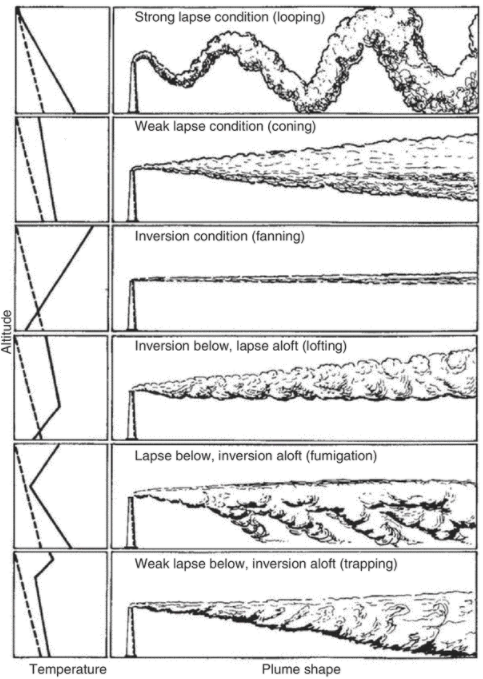

This is captured by the atmospheric stability parameter $s$ which is given by
 
$$ s = \frac{g}{T_a} { \partial \theta \over \partial z } $$

Where $ \partial \theta \over \partial z $ is the lapse rate in K/m

A default lapse rate can be used for class F stability, ${ \partial \theta \over \partial z } = 0.035 K/m$

In [8]:
g = 9.80616  # gravity, m/s^2
Γ = 0.035    # default lapse rate K/m
s = (g/Tₐ)*Γ # stability

0.001151730201342282

## Effective Stack Height



In [9]:
uⱼ > 1.5u

true

The following assumes a *stable* plume rise, Pasquill stability class F corresponds to very stable conditions.

The next step is to determine whether not the plume rise is dominated by buoyancy or by momentum. For buoyant plume rise to dominate the actual temperature difference -- the difference between the release temperature and the ambient temperature -- must be greater than a critical temperature difference $\left( \Delta T \right)_c $

$$ T_r - T_a \gt \left( \Delta T \right)_c = 0.019582 T_r u_j \sqrt{s} $$


In [10]:
ΔTc = 0.019582*Tᵣ*uⱼ* √(s)

(Tᵣ - Tₐ) > ΔTc

true

In this case buoyant plume rise is dominant, and the stable plume rise equation is

$$ \Delta h = 2.6 \left( F_b \over u_s s \right)^{1/3} $$

where $\Delta h$ is the increase in effective stack height due to plume rise, and $F_b$ is the buoyancy flux parameter

$$ F_b = g v_s D_s^2 { \left( T_r - T_a \right) \over 4 T_r } $$

Plume rise is not instantaneous, however, and the distance to the final rise, $x_f$ is given by

$$ x_f = 2.0715 {u_s \over \sqrt{s}} $$

with any distance closer to the source than $x_f$ experiencing a lesser plume rise, given by

$$ \Delta h = 1.60 \left( F_b x^2 \over u_s^3 \right)^{1/3} $$

this can be put together into a function that calculates $ \Delta h$ as a function of distance *x*

In [11]:
Fb =  g*uⱼ*(Dⱼ^2)*(Tᵣ - Tₐ)/(4Tᵣ)

function Δh(x)
    xf = 2.0715*u/√(s)
    stable_rise = 2.6*(Fb/(u*s))^(1/3)
    
    if x < xf
        return min( 1.60*(Fb*x^2/u^3)^(1/3), stable_rise)
    else
        return stable_rise
    end
    
end

Δh (generic function with 1 method)

In [12]:
sy(x) = 0.0674*x^0.9
sz(x) = 0.01122*(x^1.4024)*exp(-0.0540*log(x)^2)

function c_plume(x, y, z)
    hₑ  = h + Δh(x)
    σyₑ = √( (Δh(x)/3.5)^2 + sy(x)^2 )
    σzₑ = √( (Δh(x)/3.5)^2 + sz(x)^2 )
    
    C = (Q/(2*π*u*σyₑ*σzₑ)) *
         exp(-0.5*(y/σyₑ)^2) *
         ( exp(-0.5*((z-hₑ)/σzₑ)^2) + exp(-0.5*((z+hₑ)/σzₑ)^2) )
    
end

c_plume (generic function with 1 method)

This is exactly what the `GasDispersion.jl` gaussian plume model generates for this scenario.

In [13]:
ex2 = Scenario(ex1, release_height=h, release_temperature=Tᵣ, ambient_temperature=Tₐ)

gauss_plume = plume(ex2, GaussianPlume(plumerise=true, downwash=true))

GasDispersion.GaussianPlumeSolution(Scenario(0.1, missing, 0.1, 10.393792201919695, missing, missing, 450, 1.0, 2.0, missing, missing, 298, "F"), :gaussian, 1.0, GasDispersion.var"#36#44"{Float64}(Core.Box(122.07860435764894), Core.Box(8.692161633819795), 0.08606847099718935, Core.Box(2.0)), GasDispersion.Dispersion(:crosswind, :eqn1, 0.0674, 0.9, 0.0), GasDispersion.Dispersion(:vertical, :eqn2, 0.01122, 1.4024, -0.054))

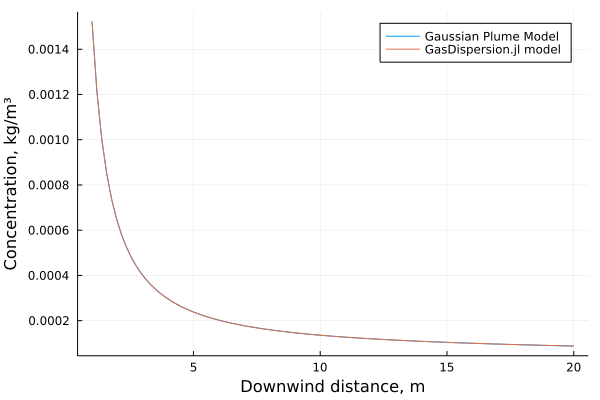

In [14]:
xs = range(1, 20, length = 100)

plot(xs, x->c_plume(x, 0, h), lab="Gaussian Plume Model")
plot!(xs, x->gauss_plume(x, 0, h), lab="GasDispersion.jl model")
plot!(ylabel="Concentration, kg/m³", xlabel="Downwind distance, m")


Using the `Plots` library contour plots showing the concentration profile of the plume can be easily generated.

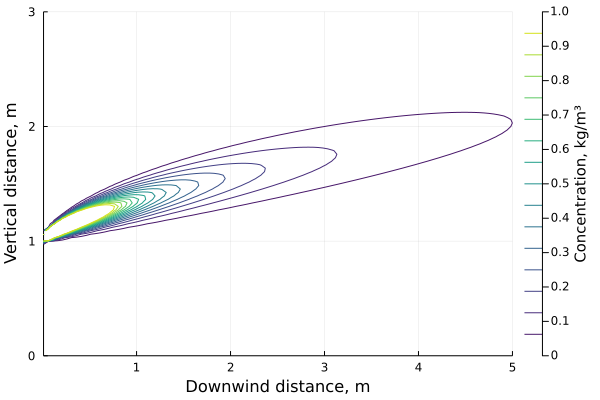

In [15]:
xs = range(0.01, 5, length=100)
zs = range(0, 3, length=100)

contour(xs, zs, (x,z)->gauss_plume(x, 0, z), c=:viridis, fill=false,
        clim=(0,1), colorbar_title="Concentration, kg/m³",
        xlabel="Downwind distance, m",
        ylabel="Vertical distance, m")

# Gaussian Puff

A gaussian puff model assumes the release is instantaneous, and all mass is concentrated in a single point. The cloud then disperses as it moves downwind with the concentration profile is given by a series of gaussians with dispersions $\sigma_x$, $\sigma_y$, and $\sigma_z$, which are found from correlations tabulated per stability class. Similarly to the plume model, a ground reflection term is included to correct for the fact that material cannot pass through the ground.

$$ c_{puff} = { m \over { (2 \pi)^{3/2} \sigma_x \sigma_y \sigma_z } } 
\exp \left( -\frac{1}{2} \left( {x - ut} \over \sigma_x \right)^2 \right) 
\exp \left( -\frac{1}{2} \left( {y} \over \sigma_y \right)^2 \right) \\
\times \left[ \exp \left( -\frac{1}{2} \left( {z - h} \over \sigma_z \right)^2 \right) 
+ \exp \left( -\frac{1}{2} \left( {z + h} \over \sigma_z \right)^2 \right)\right]$$

with
- $c_{puff}$ - mass concentration (kg/m^3)
- *m* - mass of release (kg)
- *u* - windspeed (m/s)
-  $\sigma_x$  - downwind dispersion (m)
-  $\sigma_y$  - crosswind dispersion (m)
-  $\sigma_z$  - vertical dispersion (m)
- *h* - release elevation (m)

The model assumes the initial release is a single point, with no dimensions. It is often worthwhile to estimate the initial dimensions of the cloud and calculate a *virtual* emission point to compensate for this.

Unlike the plume model, this concentration is a function of time.

### Example
This scenario is adapted from *Guidelines for Consequence Analysis of Chemical Releases*, pg 101, where we are given the following for a chemical release

- mass emission rate - 0.1kg/s
- release duration - 10s
- release elevation - 0m
- windspeed - 2m/s
- stability - F
- pressure - 1atm
- temperature - 298K

and we wish to determine the groundlevel concentration at a point 500m downwind when the center of the cloud reaches it, this could be at the fenceline for example.

In [16]:
m = 1.0
t = 1.0
h = 0.0
u = 2.0

x₁ = 500.0
t₁ = x₁/u

# the reference calculates σx incorrectly
# using σx = 0.02*x₁^0.92
σx = 0.02*x₁^0.89
σy = σx
σz = 0.05*x₁^0.61

c₁ = m / (√(2π)*π*σx*σy*σz)

0.0022500485395327723

In [17]:
ex = Scenario( Dict([
    :mass_emission_rate => m,
    :release_duration => t,
    :release_height => h,
    :windspeed => u,
    :pasquill_gifford => "F"
]))

c_pf = puff(ex, GaussianPuff())

c_pf(x₁, 0, h, t₁) ≈ c₁

true